## <font color='darkblue'>Preface</font>
([article source](https://towardsdatascience.com/feature-engineering-examples-binning-categorical-features-9f8d582455da)) <font size='3ptx'>**How to use NumPy or Pandas to quickly bin categorical features**</font>

**Working with categorical data for machine learning** (<font color='brown'>ML</font>) **purposes can sometimes present tricky issues**. Ultimately these features need to be numerically encoded in some way so that an ML algorithm can actually work with them.

You’ll also want to consider additional methods for getting your categorical features ready for modeling. For example, your model performance may benefit from **binning categorical features**. This essentially means lumping multiple categories together into a single category. By applying domain knowledge, you may be able to engineer new categories and features that better represent the structure of your data.

**In this post, we’ll briefly cover why binning categorical features can be beneficial. Then we’ll walk through three different methods for binning categorical features with specific examples using NumPy and Pandas.**

### <font color='darkgreen'>Agenda</font>
* <font size='3ptx'>[**Why Bin Categories?**](#sect1)</font>
* <font size='3ptx'>[**Using np.where() to Bin Categories**](#sect2)</font>
* <font size='3ptx'>[**Mapping Categories into New Groups with map()**](#sect3)</font>
* <font size='3ptx'>[**Applying a Custom Function with apply()**](#sect4)</font>

<a id='sect1'></a>
## <font color='darkblue'>Why Bin Categories?</font>
With categorical features, you may encounter problems with rare labels, categories/groups that are extremely uncommon within your dataset. This issue is often related to features having **high cardinality — in other words, many different categories.**

Having too many categories, and especially rare categories, leads to a noisy dataset. It can be difficult for an ML algorithm to cut through this noise and learn from the more meaningful signals in the data.

**High cardinality can also exacerbate the [curse of dimensionality](https://towardsdatascience.com/the-curse-of-dimensionality-minus-the-curse-of-jargon-520da109fc87) if you choose to [one hot encode](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd) your categorical features.** If the original variable has 50 different categories, you’re basically adding 49 columns to your dataset.

**Having too many categories can also lead to issues when training and testing your model.** It’s completely possible that a category will show up in the test set, but not in the training set. Your model would have no idea how to handle that category because it has never “seen” it before.

**One way to address these problems is by [engineering new features](https://maxsteele731.medium.com/what-is-feature-engineering-bfd25b2b26b2) that have fewer categories. This can be accomplished through binning** (<font color='brown'>grouping</font>) **multiple categories into a single category.**

In the following examples, we’ll be exploring and engineering features from a dataset with information about voter demographics and participation. I’ve selected 3 categorical variables to work with:
* **party_cd:** a registered voter’s political party affiliation
* **voting_method:** how a registered voter cast their ballot in the election
* **birth_state:** the U.S. state or territory where a registered voter was born

In [19]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import OrderedDict

In [61]:
def gen_fake_df(k=20000):
    datas = []
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population
    # https://www.ssa.gov/international/coc-docs/states.html
    us_states_weights = OrderedDict({
        'AL': 4921532, 
        'AK': 731158, 
        'AS': 19437, 
        'AZ': 7421401, 
        'AR': 3030522, 
        'CA': 39368, 
        'CO': 5807719,
        'CT': 3557006,
        'DE': 986809,
        'DC': 712816,
        'FL': 21733312,
        'GA': 10710017,
        'GU': 68485,
        'HI': 1407006,
        'ID': 1826913,
        'IL': 12587530,
        'IN': 6754953,
        'IA': 3163561,
        'KS': 2913805,
        'KY': 4477251,
        'LA': 4645318,
        'ME': 1350141,
        'MD': 6055802,
        'MA': 6893574,
        'MI': 9966555,
        'MN': 5657342,
        'MS': 2966786,
        'MO': 6151548,
        'MT': 1080577,
        'NE': 1937552,
        'NV': 3138259,
        'NH': 1366275,
        'NJ': 8882371,
        'NM': 2106319,
        'NY': 10600823*5,
        'NC': 10600823*9,
        'Missing': 10600823*7,
        'ND': 765309,
        'NP': 51433,
        'OH': 11693217,
        'OC': 10600823*2,
        'OK': 3980783,
        'OR': 4241507,
        'PA': 12783254,
        'PR': 189068,
        'SC': 5218040,
        'TX': 29360759,
        'UT': 3249879,
        'VA': 8590563,
        'WA': 7693612,
    })
    vote_method_weights = OrderedDict({
        'ABSENTEE ONESTOP': 8300, 
        'NO VOTE': 3900,
        'IN PERSON': 2000,
        'ABSENTEE BY MAIL': 1900,
        'ABSENTEE CURBSIDE': 500,
        'PROVISIONAL': 60,
        'TRANSFER': 40,
        'CURBSIDE': 30,
    })
    for v, p, b in zip(
        random.choices(list(vote_method_weights.keys()), weights=tuple(vote_method_weights.values()), k=k),
        random.choices(['REP', 'UNA', 'DEM', 'LIB', 'CST', 'GRE'], weights=(6900, 5700, 4000, 100, 100, 90), k=k),
        random.choices(list(us_states_weights.keys()), weights=tuple(list(us_states_weights.values())), k=k),
    ):
        datas.append((v, p, b))
    df = pd.DataFrame(datas, columns = ["voting_method", "party_cd", "birth_state"])
    return df

In [55]:
fake_df = gen_fake_df()
fake_df.head()

,voting_method,party_cd,birth_state
0,ABSENTEE ONESTOP,LIB,Missing
1,ABSENTEE BY MAIL,DEM,OC
2,ABSENTEE ONESTOP,REP,WA
3,ABSENTEE BY MAIL,UNA,IL
4,NO VOTE,REP,Missing


<a id='sect2'></a>
## <font color='darkblue'>Using np.where() to Bin Categories</font>
First, let’s check out why I chose `party_cd`. The image below shows how many individual voters belong to each political party.

<AxesSubplot:>

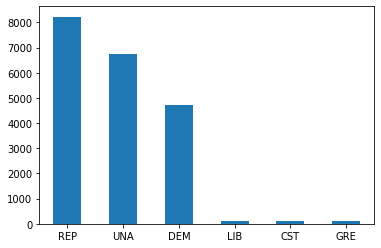

In [28]:
plt.rcParams['figure.figsize'] = [6, 4]
fake_df['party_cd'].value_counts().plot(kind='bar', rot=0)

There are so few registered Libertarians, Constitutionalists, and members of the Green Party that we can barely see them on the graph. These would be good examples of rare labels. **For the purposes of this post, we’ll define rare labels as those that make up less than 5% of observations. This is a common threshold for defining rare labels, but ultimately that’s up to your discretion.**

Let’s look at a breakdown of the actual numbers:

In [46]:
def show_column_dist(df, column_name, top_n=-1):
    # https://stackoverflow.com/questions/50558458/pandas-get-frequency-of-item-occurrences-in-a-column-as-percentage
    a, fake_df_row_count = fake_df[column_name].value_counts(), fake_df.shape[0]
    dist_df = pd.DataFrame(a.tolist(), columns = [column_name], index=a.index)
    dist_df['%'] = dist_df.apply(lambda e: 100*e[column_name]/fake_df_row_count, axis=1)
    if top_n > 0:
        return dist_df.head(n=15)
    else:
        return dist_df

In [30]:
fake_df['party_cd'].value_counts()

REP    8223
UNA    6733
DEM    4716
LIB     116
CST     114
GRE      98
Name: party_cd, dtype: int64

In [44]:
show_column_dist(fake_df, 'party_cd')

,party_cd,%
REP,8223,41.115
UNA,6733,33.665
DEM,4716,23.580
LIB,116,0.580
CST,114,0.570
GRE,98,0.490


Those three categories each make up far less than 5% of the population. Even if we lumped them all together into a single category, that new category would still represent less than 1% of voters.

`REP` and `DEM` represent the two major political parties, whereas `UNA` represents voters that registered as unaffiliated with a political party. So here, it could make sense to lump in our three rare labels into that unaffiliated group so that we have three categories: one for each of the two major parties, and a third representing individuals that chose not to align with either major party.

This can be accomplished very easily with [**np**.where()](https://numpy.org/doc/stable/reference/generated/numpy.where.html) which takes 3 arguments:
1. a condition
2. what to return if the condition is met
3. what to return if the condition is not met

The following code creates a new feature, `party_grp`, from the original `party_cd` variable using [**np**.where()](https://numpy.org/doc/stable/reference/generated/numpy.where.html):

In [32]:
fake_df['party_grp'] = np.where(
    fake_df['party_cd'].isin(['REP', 'DEM']),
    fake_df['party_cd'].str.title(),
    'Other'
)

In [33]:
fake_df[['party_cd', 'party_grp']]

,party_cd,party_grp
0,DEM,Dem
1,DEM,Dem
2,DEM,Dem
3,REP,Rep
4,REP,Rep
...,...,...
19995,UNA,Other
19996,REP,Rep
19997,DEM,Dem
19998,REP,Rep


In [34]:
show_column_dist(fake_df, 'party_grp')

,party_grp,%
Rep,8223,41.115
Other,7061,35.305
Dem,4716,23.580


<a id='sect3'></a>
## <font color='darkblue'>Mapping Categories into New Groups with map()</font>
Next up, let’s take a look at the distribution of `voting_method`:

<AxesSubplot:>

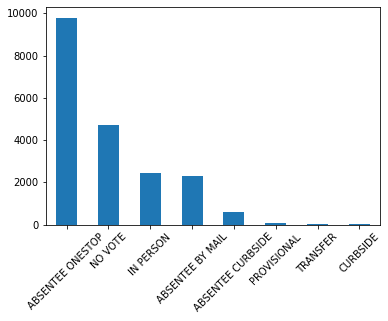

In [36]:
plt.rcParams['figure.figsize'] = [6, 4]
fake_df['voting_method'].value_counts().plot(kind='bar', rot=45)

Not the prettiest of graphs, but we get the picture. **We have 8 different categories of voting method. I would hazard a guess that half of them meet our definition of rare labels.**

In [37]:
show_column_dist(fake_df, 'voting_method')

,voting_method,%
ABSENTEE ONESTOP,9804,49.020
NO VOTE,4697,23.485
IN PERSON,2451,12.255
ABSENTEE BY MAIL,2324,11.620
ABSENTEE CURBSIDE,580,2.900
PROVISIONAL,65,0.325
TRANSFER,41,0.205
CURBSIDE,38,0.190


Yup! Four of our categories are rare labels. **<font color='darkred'>Now we could just group them all into an “Other” category and call it a day, but this may not be the most appropriate method.</font>**

Based on research I did into how these methods are coded, I know that `Absentee` means someone voted early. So we could group any `Absentee` method into an `Early` category, group `In-Person` and `Curbside` into an `Election Day` category, leave `No Vote` as its own category, and group `Provisional` and `Transfer` into an `Other` category.

The following code accomplishes this by first defining a dictionary using the original `voting_method` categories as keys. The value for each key is the new category we actually want.

In [38]:
vote_method_map = {'ABSENTEE ONESTOP': 'Early',
                   'IN PERSON': 'Election Day',
                   'ABSENTEE BY MAIL': 'Early',
                   'ABSENTEE CURBSIDE': 'Early',
                   'TRANSFER': 'Other',
                   'PROVISIONAL': 'Other',
                   'CURBSIDE': 'Election Day',
                   'NO VOTE': 'No Vote'}

fake_df['vote_method_cat'] = fake_df['voting_method'].map(vote_method_map)

In [39]:
fake_df[['voting_method', 'vote_method_cat']]

,voting_method,vote_method_cat
0,ABSENTEE ONESTOP,Early
1,IN PERSON,Election Day
2,ABSENTEE ONESTOP,Early
3,NO VOTE,No Vote
4,IN PERSON,Election Day
...,...,...
19995,ABSENTEE ONESTOP,Early
19996,ABSENTEE ONESTOP,Early
19997,ABSENTEE BY MAIL,Early
19998,NO VOTE,No Vote


That last line creates a new column, `vote_method_cat`, based on the original values in the `voting_method` column. It does so by applying Pandas’ [map()](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html) method to the original column, and feeding in our `vote_method_map` to translate from key to corresponding value.

In [40]:
show_column_dist(fake_df, 'vote_method_cat')

,vote_method_cat,%
Early,12708,63.540
No Vote,4697,23.485
Election Day,2489,12.445
Other,106,0.530


Now we’ve gotten rid of all but one of our rare labels. Ultimately I chose to drop those 106 `Other` votes. **Voting method was actually the target variable I was trying to predict and what I was really interested in was how people chose to vote**. Provisional and transfer ballots are more reflective of the process and regulations surrounding voting, but my question was specifically about a voter’s active choice.

**So not only can you think about engineering predictive features to better represent the underlying structure of your data, <font color='darkgreen'>you can consider how best to represent your target variable relative to your specific question</font>.**

<a id='sect4'></a>
## <font color='darkblue'>Applying a Custom Function with apply()</font>
Finally, we’re going to work on binning `birth_state`. This variable has 57 categories: one for each state, one for missing information, one for each U.S. territory, and a final category for individuals born outside the United States.

So the graph looks comically terrible:

<AxesSubplot:>

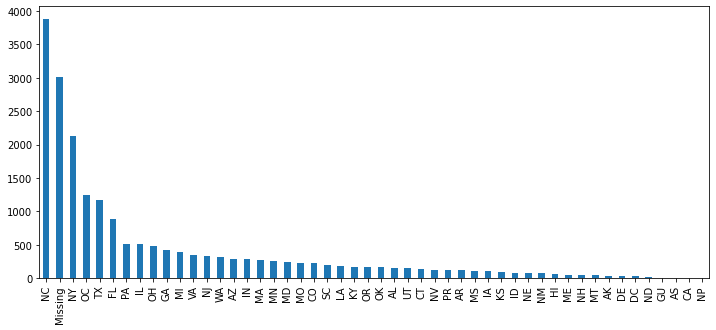

In [62]:
plt.rcParams['figure.figsize'] = [12, 5]
fake_df['birth_state'].value_counts().plot(kind='bar', rot=90)

If you ever see a graph like this while exploring categorical features, **that’s a good indication you should consider binning that variable if you intend to use it as a feature in your model.**

Below is the breakdown of the 15 most common categories of `birth_state`:

In [63]:
show_column_dist(fake_df, 'birth_state', top_n=15)

,birth_state,%
NC,3874,19.370
Missing,3009,15.045
NY,2127,10.635
OC,1238,6.190
TX,1176,5.880
FL,886,4.430
PA,515,2.575
IL,509,2.545
OH,482,2.410
GA,423,2.115


North Carolina `NC` is the most common state, which makes sense since this data is for voters in a specific county in `NC`. Then we see lots of missing values `Missing`. New Yorkers `NY` and people born outside the U.S. `OC` also make up a decent portion of the population. The remaining 53 categories are rare labels based on our definition and will introduce a lot of noise into our modeling efforts.

Let’s group states by [U.S. Census region](https://www.census.gov/geographies/reference-maps/2010/geo/2010-census-regions-and-divisions-of-the-united-states.html) (<font color='brown'>Northeast, South, Midwest, West</font>). We’ll also group people born in U.S. territories or outside the country into an “`Other`” group, and leave “`Missing`” as its own category.

We’ll do this by defining our own custom function to translate from state to region, then apply that function to our original variable to get our new feature. Here’s one way you could write a function to check each state and return the desired region/category:

In [64]:
## Define function for grouping birth state/country into categories
def get_birth_reg(state):
    
    # check if U.S. territory or out of country
    if state in ['AS', 'GU', 'MP', 'PR', 'VI', 'OC']:
        return 'Other'
    
    # the rest of the categories are based on U.S. Census Bureau regions
    elif state in ['CT', 'ME', 'MA', 'NH', 'RI', 'VT',
                     'NJ', 'NY', 'PA']:
        return 'Northeast'
    
    elif state in ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 
                     'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR',
                     'LA', 'OK', 'TX']:
        return 'South'
    
    elif state in ['IL', 'IN', 'MI', 'OH', 'WI',
                     'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']:
        return 'Midwest'
    
    elif state in ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT',
                     'WY', 'AK', 'CA', 'HI', 'OR', 'WA']:
        return 'West'
    
    else:
        return 'Missing'

And now to use Pandas’ [apply()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) method to create our new feature:

In [65]:
fake_df['birth_reg'] = fake_df['birth_state'].apply(get_birth_reg)

In [66]:
show_column_dist(fake_df, 'birth_reg')

,birth_reg,%
South,8116,40.580
Northeast,3485,17.425
Missing,3010,15.050
Midwest,2445,12.225
West,1575,7.875
Other,1369,6.845


Much better! We’ve gone from 57 total categories with 53 rare labels to only 6 categories.